ATTENTION AND TRANSFORMER MODEL

In [ ]:
#attention model
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu


from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
   from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_path='/content/drive/MyDrive/ImageDataset/Flicker8k_Dataset/'

In [ ]:
##download token dataset
!gdown --id "1o6S-v9W2YXnhhlp2CzdLrPvxFyJG8uxb"

Downloading...
From: https://drive.google.com/uc?id=1o6S-v9W2YXnhhlp2CzdLrPvxFyJG8uxb
To: /content/Flickr8k.token.txt
100% 3.40M/3.40M [00:00<00:00, 109MB/s]


In [ ]:
tokenpath="/content/Flickr8k.token.txt"

In [ ]:
##to find the images
imagesize = os.listdir(image_path)

In [ ]:
print("Total Images in Dataset = {}".format(len(imagesize)))

Total Images in Dataset = 16192


In [ ]:
file = open(tokenpath,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
   col = line.split('\t')
   if len(col) == 1:
       continue
   w = col[0].split("#")
   datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)

data.head()

index  ...                                            caption
0     0  ...  a child in a pink dress is climbing up a set o...
1     1  ...              a girl going into a wooden building .
2     2  ...   a little girl climbing into a wooden playhouse .
3     3  ...  a little girl climbing the stairs to her playh...
4     4  ...  a little girl in a pink dress going into a woo...

[5 rows x 3 columns]

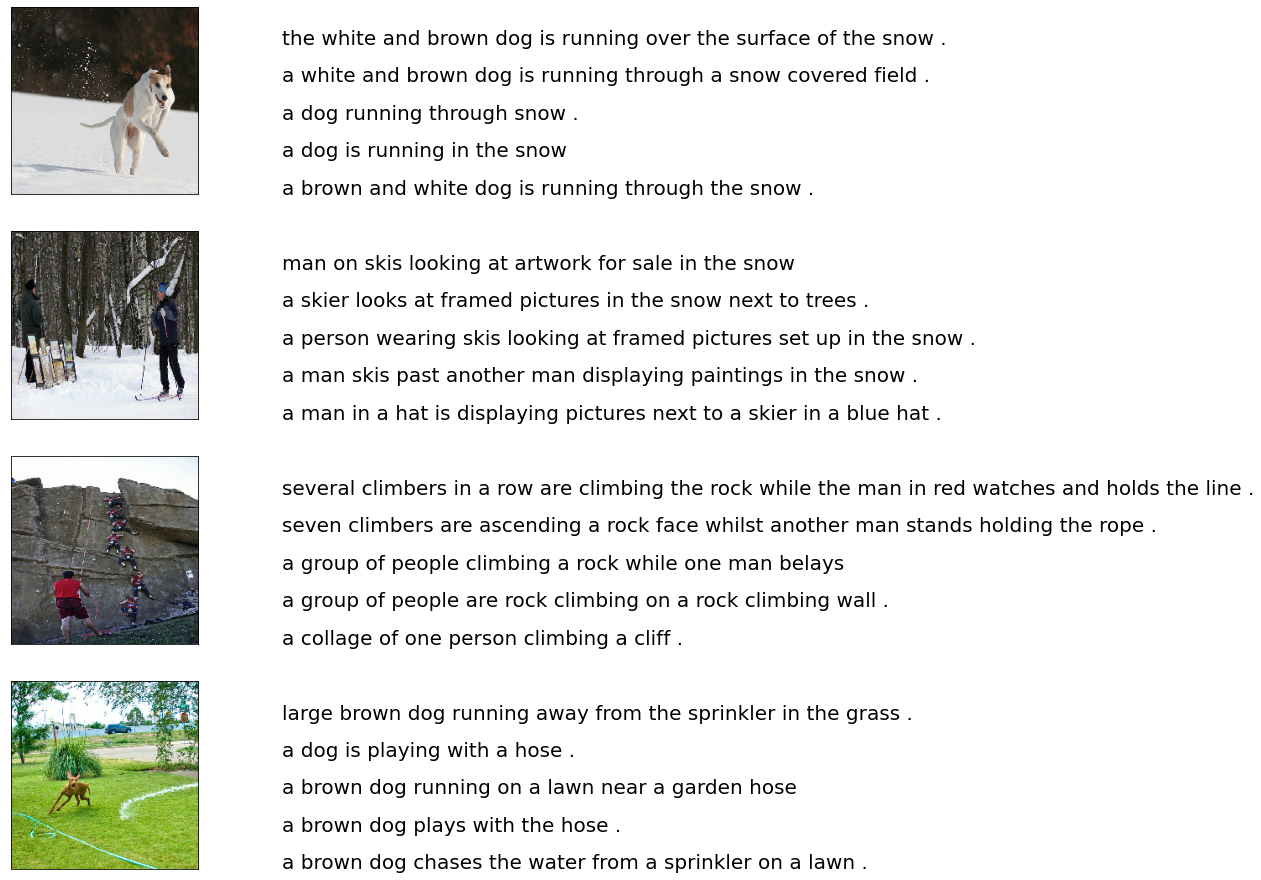

In [ ]:
#Visualizing images with its caption
npic = 5 
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:14]:
   filename = image_path + '/' + jpgfnm
   captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
   image_load = load_img(filename, target_size=target_size)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=20)
   count += 1
plt.show()

In [ ]:
#validating the vocabulary size
vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8918


In [ ]:
#Performing text cleaning
def remv_ption(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remv_nmric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remv_ption(text_original)
   text = remove_single_character(text)
   text = remv_nmric(text)
   return(text)

for i, caption in enumerate(data.caption.values):
   newcaption = text_clean(caption)
   data["caption"].iloc[i] = newcaption

In [ ]:
#Cheking the vocabulary size after cleaning
clean_vocabulary = []
for txt in data.caption.values:
   clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 8357


In [ ]:
#adding start and end to the captions
PATH = '/content/drive/MyDrive/ImageDataset/Flicker8k_Dataset/'
all_captions = []
for caption  in data["caption"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

all_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [ ]:
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = PATH + annot
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['/content/drive/MyDrive/ImageDataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/ImageDataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/ImageDataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/ImageDataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/ImageDataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/ImageDataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/ImageDataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/ImageDataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/ImageDataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/ImageDataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg']

In [ ]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


In [ ]:
#limiting the image size to 40000 for proper training batches of 625 and so having the batch size as 65
def data_limiter(num,all_captions,all_img_name_vector):
  train_captions, img_name_vector = shuffle(all_captions,all_img_name_vector,random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector

 


In [ ]:
train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)

In [ ]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = preprocess_input(img)
   return img, image_path

image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [ ]:

for img, path in tqdm(image_dataset):
 batch_features = image_features_extract_model(img)
 batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))

 for bf, p in zip(batch_features, path): 
   path_of_feature = p.numpy().decode("utf-8")
   np.save(path_of_feature, bf.numpy())

100%|██████████| 127/127 [05:36<00:00,  2.65s/it]


In [ ]:
#tokenizing and building vocabulary for all unique words and limiting the vocab size to 5000 to save memory and converting the words to unk which are not in vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
#padded training
train_captions[:3]

['<start>  several children leaping into pile of leaves on the ground <end>',
 '<start>  man hiking in the wilderness giving the camera thumbs up <end>',
 '<start>  white dog is running through the water onto the shore <end>']

In [ ]:
#tokenized vectors
train_seqs[:3]

[[2, 184, 62, 331, 64, 524, 12, 329, 6, 5, 167, 3],
 [2, 11, 588, 4, 5, 2384, 895, 5, 93, 1281, 53, 3],
 [2, 14, 9, 7, 32, 33, 5, 24, 238, 5, 280, 3]]

In [ ]:
#checking the max and min length for all captions
def calc_max_length(tensor):
   return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
   return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 33 : 2


In [ ]:
#training and validation split of 80:20
img_name_train, image_name_validation, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)

In [ ]:
#training parameters pART2
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

In [ ]:
##PART 2
#creating a dataset for training the model
def map_func(img_name, cap):
 img_tensor = np.load(img_name.decode('utf-8')+'.npy')
 return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
#pART2
#defining encoder-decoder architecture with attention mechanism
class VGG16_Encoder(tf.keras.Model):
   # This encoder passes the features through a Fully connected layer
   def __init__(self, embedding_dim):
       super(VGG16_Encoder, self).__init__()
       # shape after fc == (batch_size, 49, embedding_dim)
       self.fc = tf.keras.layers.Dense(embedding_dim)
       self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

   def call(self, x):
       #x= self.dropout(x)
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x   

In [ ]:
#part2
def rnn_type(units):
   if tf.test.is_gpu_available():
       return tf.compat.v1.keras.layers.CuDNNLSTM(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
   else:
       return tf.keras.layers.GRU(units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_activation='sigmoid',
                                  recurrent_initializer='glorot_uniform')

In [ ]:
#part2
'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

class Rnn_Local_Decoder(tf.keras.Model):
 def __init__(self, embedding_dim, units, vocab_size):
   super(Rnn_Local_Decoder, self).__init__()
   self.units = units
   self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
   self.gru = tf.keras.layers.GRU(self.units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
  
   self.fc1 = tf.keras.layers.Dense(self.units)

   self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
   self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

   self.fc2 = tf.keras.layers.Dense(vocab_size)

   # Implementing Attention Mechanism
   self.Uattn = tf.keras.layers.Dense(units)
   self.Wattn = tf.keras.layers.Dense(units)
   self.Vattn = tf.keras.layers.Dense(1)

 def call(self, x, features, hidden):
   # features shape ==> (64,49,256) ==> Output from ENCODER
   # hidden shape == (batch_size, hidden_size) ==>(64,512)
   # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

   hidden_with_time_axis = tf.expand_dims(hidden, 1)

   # score shape == (64, 49, 1)
   # Attention Function
   '''e(ij) = f(s(t-1),h(j))'''
   ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''

   score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

   # self.Uattn(features) : (64,49,512)
   # self.Wattn(hidden_with_time_axis) : (64,1,512)
   # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
   # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score

   # you get 1 at the last axis because you are applying score to self.Vattn
   # Then find Probability using Softmax
   '''attention_weights(alpha(ij)) = softmax(e(ij))'''

   attention_weights = tf.nn.softmax(score, axis=1)

   # attention_weights shape == (64, 49, 1)
   # Give weights to the different pixels in the image
   ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) '''

   context_vector = attention_weights * features
   context_vector = tf.reduce_sum(context_vector, axis=1)

   # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
   # context_vector shape after sum == (64, 256)
   # x shape after passing through embedding == (64, 1, 256)

   x = self.embedding(x)
   # x shape after concatenation == (64, 1,  512)

   x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
   # passing the concatenated vector to the GRU

   output, state = self.gru(x)
   # shape == (batch_size, max_length, hidden_size)

   x = self.fc1(output)
   # x shape == (batch_size * max_length, hidden_size)

   x = tf.reshape(x, (-1, x.shape[2]))

   # Adding Dropout and BatchNorm Layers
   x= self.dropout(x)
   x= self.batchnormalization(x)

   # output shape == (64 * 512)
   x = self.fc2(x)

   # shape : (64 * 8329(vocab))
   return x, state, attention_weights

 def reset_state(self, batch_size):
   return tf.zeros((batch_size, self.units))


encoder = VGG16_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

In [ ]:
#Part2
#loss function and optimizer
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')

def loss_function(real, pred):
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 loss_ = loss_object(real, pred)
 mask = tf.cast(mask, dtype=loss_.dtype)
 loss_ *= mask

 return tf.reduce_mean(loss_)

Attention Model Training

In [ ]:
#part2
#model training
loss_plot = []

@tf.function
def train_step(img_tensor, target):
 loss = 0
 # initializing the hidden state for each batch
 # because the captions are not related from image to image

 hidden = decoder.reset_state(batch_size=target.shape[0])
 dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

 with tf.GradientTape() as tape:
     features = encoder(img_tensor)
     for i in range(1, target.shape[1]):
         # passing the features through the decoder
         predictions, hidden, _ = decoder(dec_input, features, hidden)
         loss += loss_function(target[:, i], predictions)

         # using teacher forcing
         dec_input = tf.expand_dims(target[:, i], 1)

 total_loss = (loss / int(target.shape[1]))
 trainable_variables = encoder.trainable_variables + decoder.trainable_variables
 gradients = tape.gradient(loss, trainable_variables)
 optimizer.apply_gradients(zip(gradients, trainable_variables))

 return loss, total_loss

In [ ]:
#part2
#model training
#EPOCHS = 20
EPOCHS= 30

for epoch in range(EPOCHS):
   start = time.time()
   total_loss = 0

   for (batch, (img_tensor, target)) in enumerate(dataset):
       batch_loss, t_loss = train_step(img_tensor, target)
       total_loss += t_loss

       if batch % 100 == 0:
           print ('Epoch {} Batch {} Loss {:.4f}'.format(
             epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
   # storing the epoch end loss value to plot later
   loss_plot.append(total_loss / num_steps)

   print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                        total_loss/num_steps))

   print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.7464
Epoch 1 Batch 100 Loss 1.6757
Epoch 1 Batch 200 Loss 1.3648
Epoch 1 Batch 300 Loss 1.3805
Epoch 1 Batch 400 Loss 1.3519
Epoch 1 Loss 1.431033
Time taken for 1 epoch 94.11186456680298 sec

Epoch 2 Batch 0 Loss 1.1548
Epoch 2 Batch 100 Loss 1.1397
Epoch 2 Batch 200 Loss 1.1162
Epoch 2 Batch 300 Loss 1.1235
Epoch 2 Batch 400 Loss 1.0522
Epoch 2 Loss 1.110943
Time taken for 1 epoch 55.107197761535645 sec

Epoch 3 Batch 0 Loss 1.1067
Epoch 3 Batch 100 Loss 0.9970
Epoch 3 Batch 200 Loss 1.0480
Epoch 3 Batch 300 Loss 0.9494
Epoch 3 Batch 400 Loss 0.8525
Epoch 3 Loss 0.997694
Time taken for 1 epoch 54.99582242965698 sec

Epoch 4 Batch 0 Loss 0.9261
Epoch 4 Batch 100 Loss 0.8579
Epoch 4 Batch 200 Loss 0.9316
Epoch 4 Batch 300 Loss 0.8938
Epoch 4 Batch 400 Loss 0.8204
Epoch 4 Loss 0.916089
Time taken for 1 epoch 55.14109826087952 sec

Epoch 5 Batch 0 Loss 0.7924
Epoch 5 Batch 100 Loss 0.9092
Epoch 5 Batch 200 Loss 0.8317
Epoch 5 Batch 300 Loss 0.8510
Epoch 5 Batch 400

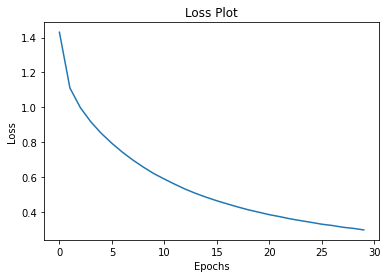

In [ ]:
#part2
##plotting loss
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
#part2
#With BLEU Evaluation 
def evaluate(image):
   attention_plot = np.zeros((max_length, attention_features_shape))

   hidden = decoder.reset_state(batch_size=1)
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

   features = encoder(img_tensor_val)
   dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
   result = []

   for i in range(max_length):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmax(predictions[0]).numpy()
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '<end>':
           return result, attention_plot

       dec_input = tf.expand_dims([predicted_id], 0)
   attention_plot = attention_plot[:len(result), :]

   return result, attention_plot
  
  

In [ ]:
 #part2
 def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (8, 8))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l])
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

In [ ]:
#part2
random = np.random.randint(0, len(image_name_validation))
image = image_name_validation[random]
start = time.time()
real_cap = ' '.join([tokenizer.index_word[i] for i in cap_val[random] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_cap.split(' ', 1)[1]
real_cap = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
final_result = result_join.rsplit(' ', 1)[0]

rl_apn = []
rl_apn.append(real_cap.split())
reference = rl_apn
candidate = final_result

print ('Real Caption:', real_cap)
print ('Prediction Caption:', final_result)

plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(image_name_validation[random])

Real Caption: girl in pink dress plays with hula hoop
Prediction Caption: blond girl paying with hula hoop


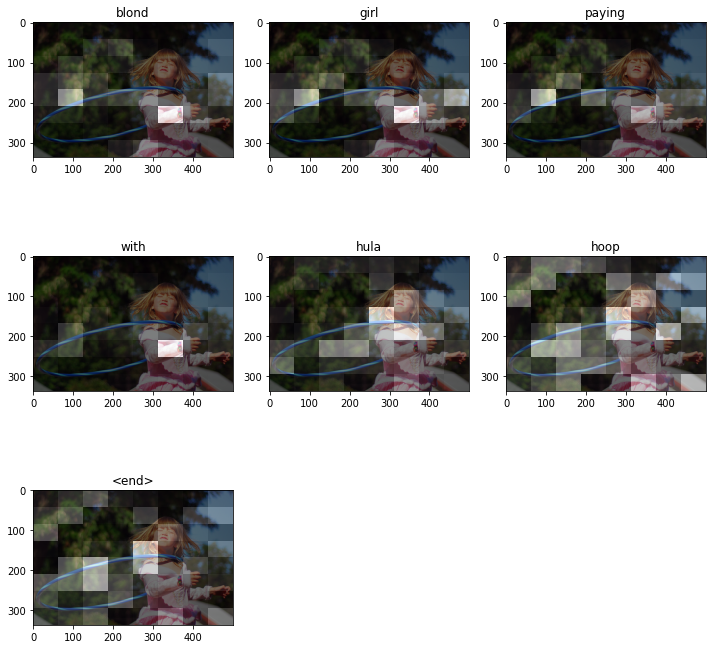

time took to Predict: 2 sec


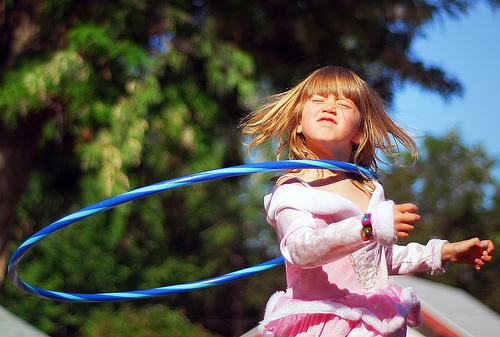

In [ ]:
#part2-random image check
random = np.random.randint(0, len(image_name_validation))
image = image_name_validation[random]
start = time.time()
real_cap = ' '.join([tokenizer.index_word[i] for i in cap_val[random] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_cap.split(' ', 1)[1]
real_cap = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
final_result = result_join.rsplit(' ', 1)[0]

rl_apn = []
rl_apn.append(real_cap.split())
reference = rl_apn
candidate = final_result

print ('Real Caption:', real_cap)
print ('Prediction Caption:', final_result)

plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(image_name_validation[random])

In [ ]:
#Part2
#Checking other caption-random image caption
random = np.random.randint(0, len(image_name_validation))
image = image_name_validation[random]

real_cap = ' '.join([tokenizer.index_word[i] for i in cap_val[random] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_cap
first = real_cap.split(' ', 1)[1]
real_cap = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_cap:
   if i=="<unk>":
       real_cap.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
final_result = result_join.rsplit(' ', 1)[0]

rl_apn = []
rl_apn.append(real_cap.split())
reference = rl_apn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_cap)
print ('Prediction Caption:', final_result)

plot_attention(image, result, attention_plot)
Image.open(image_name_validation[random])

BELU score: 47.6273899703797
Real Caption: red dog jumps an catches tennis ball in its mouth
Prediction Caption: dog is running in the grass


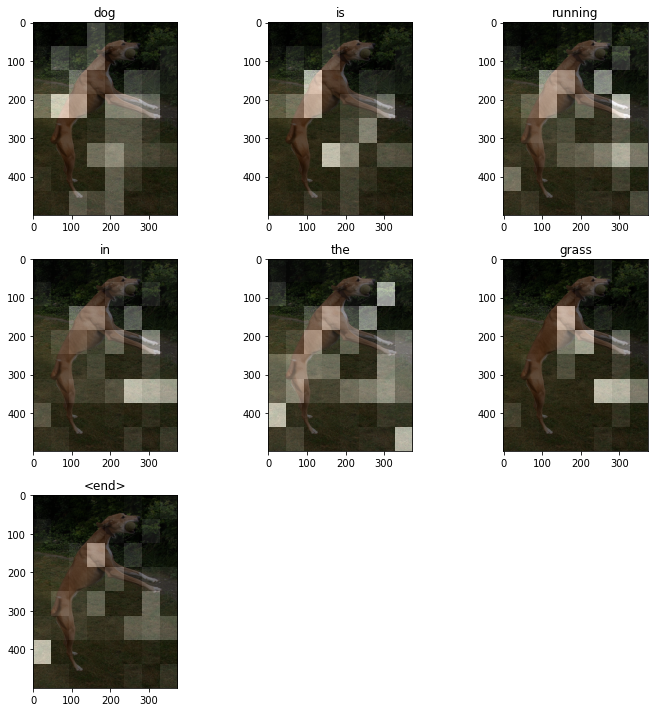

BELU score: 51.697315395717055
Real Caption: three dogs are in the snow
Prediction Caption: three dogs play in its mouth


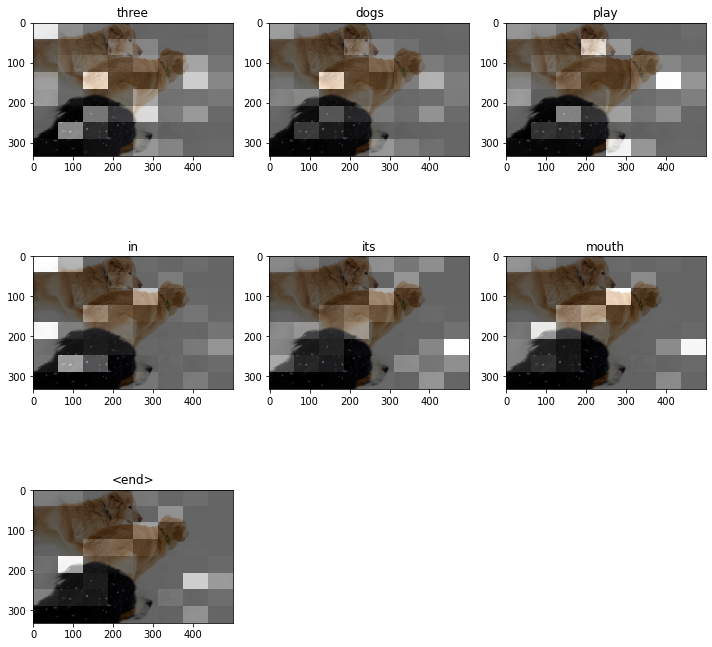

BELU score: 21.042990347620457
Real Caption: basketball player in the air about to make shot
Prediction Caption: the basketball player in white is running with each other while two basketball players in progress


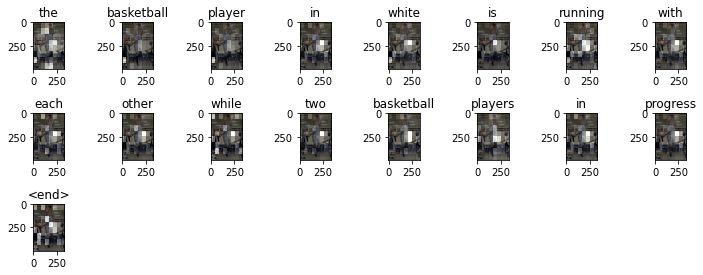

BELU score: 20.142070913129906
Real Caption: girl in pink shirt is <unk> her limbs out in midair
Prediction Caption: girl jumps on pavement


ValueError: ignored

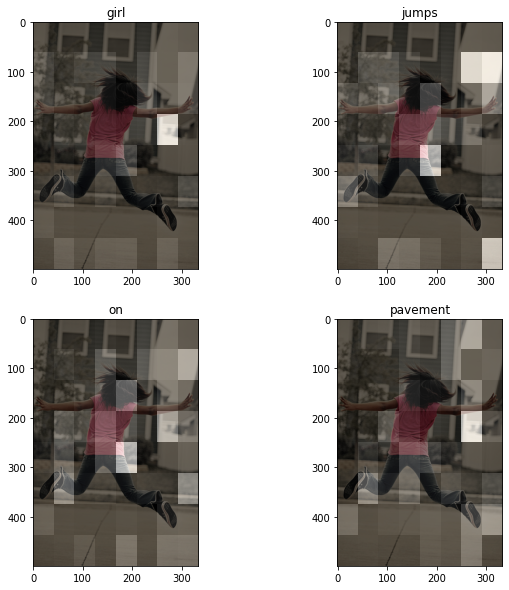

In [ ]:
###Storing the BLEU scores in array for attention mechanism
score1=[]
for random in range(10,20):
  image = image_name_validation[random]

  real_cap = ' '.join([tokenizer.index_word[i] for i in cap_val[random] if i not in [0]])
  result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_cap
  first = real_cap.split(' ', 1)[1]

  real_cap = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
  for i in result:
     if i=="<unk>":
       result.remove(i)
       

  for i in real_cap:
     if i=="<unk>":
        real_cap.remove(i)

#remove <end> from result        
  result_join = ' '.join(result)
  final_result = result_join.rsplit(' ', 1)[0]

  rl_apn = []
  rl_apn.append(real_cap.split())
  reference = rl_apn
  candidate = result


  score =sentence_bleu(reference, candidate)
  print(f"BELU score: {score*100}")
  
  score1.append(score)

  print ('Real Caption:', real_cap)
  print ('Prediction Caption:', final_result)


  plot_attention(image, result, attention_plot)
  Image.open(image_name_validation[random])



In [ ]:
###Getting image captioned by attention for uman valuattion
###Storing the BLEU scores in array for attention mechanism 
image = image_name_validation[10]
real_cap = ' '.join([tokenizer.index_word[i] for i in cap_val[random] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_cap
first = real_cap.split(' ', 1)[1]

real_cap = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
  for i in result:
     if i=="<unk>":
       result.remove(i)
       

  for i in real_cap:
     if i=="<unk>":
        real_cap.remove(i)

#remove <end> from result        
  result_join = ' '.join(result)
  final_result = result_join.rsplit(' ', 1)[0]

  rl_apn = []
  rl_apn.append(real_cap.split())
  reference = rl_apn
  candidate = result


  score =sentence_bleu(reference, candidate)
  print(f"BELU score: {score*100}")
  

  print ('Real Caption:', real_cap)
  print ('Prediction Caption:', final_result)


  plot_attention(image, result, attention_plot)
  Image.open(image_name_validation[random])



IndentationError: ignored

In [ ]:

!pip install nltk==3.5

     |████████████████████████████████| 1.4 MB 4.2 MB/s 
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434693 sha256=d430bdad73e5803598f72a11d6abbc9c0611007209249057d2c346594bd2d7f7
  Stored in directory: /root/.cache/pip/wheels/45/6c/46/a1865e7ba706b3817f5d1b2ff7ce8996aabdd0d03d47ba0266
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
from nltk.translate.meteor_score import meteor_score

In [ ]:
##calculate mean score for BLEU 1,2,3,4
scorelst= []
for random in range(len(image_name_validation)):
  image = image_name_validation[random]

  real_cap = ' '.join([tokenizer.index_word[i] for i in cap_val[random] if i not in [0]])
  result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_cap
  first = real_cap.split(' ', 1)[1]
  real_cap = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
  for i in result:
     if i=="<unk>":
       result.remove(i)
       

  for i in real_cap:
     if i=="<unk>":
        real_cap.remove(i)

#remove <end> from result        
  result_join = ' '.join(result)
  final_result = result_join.rsplit(' ', 1)[0]

  rl_apn = []
  rl_apn.append(real_cap.split())
  reference = rl_apn
  candidate = result


  score = sentence_bleu(reference, candidate,weights=(1.0,0,0,0))
  score1= scorelst.append(score)
  score1=np.mean(score1)
  print(f"BLEU1 score: {score1}")

  score = sentence_bleu(reference, candidate,weights=(0.5,0.5,0,0))
  score2= scorelst.append(score)
  score2=np.mean(score2)
  print(f"BLEU2 score: {score2}")
  score = sentence_bleu(reference, candidate,weights=(0.3,0.3,0.3,0))
  score3= scorelst.append(score)
  score3=np.mean(score3)
  print(f"BLEU3 score: {score3}")
  score = sentence_bleu(reference, candidate,weights=(0.25,0.25,0.25,0.25))
  score4= scorelst.append(score)
  score4=np.mean(score4)
  print(f"BLEU4 score: {score4}")
  



In [ ]:
##calculate mean score for BLEU 1,2,3,4
scorelst= []
for random in range(len(image_name_validation)):
  image = image_name_validation[random]

  real_cap = ' '.join([tokenizer.index_word[i] for i in cap_val[random] if i not in [0]])
  result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_cap
  first = real_cap.split(' ', 1)[1]
  real_cap = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
  for i in result:
     if i=="<unk>":
       result.remove(i)
       

  for i in real_cap:
     if i=="<unk>":
        real_cap.remove(i)

#remove <end> from result        
  result_join = ' '.join(result)
  final_result = result_join.rsplit(' ', 1)[0]

  rl_apn = []
  rl_apn.append(real_cap.split())
  reference = rl_apn
  candidate = result


  score = sentence_bleu(reference, candidate,weights=(1.0,0,0,0))
  
  scorelst.append(score)
  print(f"BLEU1 score: {np.mean(scorelst)}")
  

  




Streaming output truncated to the last 5000 lines.
BLEU1 score: 0.1998209302075133
BLEU1 score: 0.199794922127917
BLEU1 score: 0.1997838904078167
BLEU1 score: 0.1997383426860695
BLEU1 score: 0.1996996055781318
BLEU1 score: 0.19969970550974253
BLEU1 score: 0.1996678137136429
BLEU1 score: 0.19966792414791365
BLEU1 score: 0.19972241681640437
BLEU1 score: 0.19975098554361295
BLEU1 score: 0.1996947092383188
BLEU1 score: 0.1996702146697
BLEU1 score: 0.19971457680666102
BLEU1 score: 0.1997036120056856
BLEU1 score: 0.19967757834373082
BLEU1 score: 0.19966663308123844
BLEU1 score: 0.19967410924601833
BLEU1 score: 0.19964751805180017
BLEU1 score: 0.19965336488393065
BLEU1 score: 0.19966739425062108
BLEU1 score: 0.19976390899990812
BLEU1 score: 0.19977134060587182
BLEU1 score: 0.19982554670015906
BLEU1 score: 0.19983577939991737
BLEU1 score: 0.19979726619460614
BLEU1 score: 0.19987110743593156
BLEU1 score: 0.19985227229731947
BLEU1 score: 0.19984131271818117
BLEU1 score: 0.19983408271896508
BLEU1

In [ ]:
##calculate bleu2 mean score
##calculate mean score for BLEU 2
scorelst= []
for random in range(len(image_name_validation)):
  image = image_name_validation[random]

  real_cap = ' '.join([tokenizer.index_word[i] for i in cap_val[random] if i not in [0]])
  result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_cap
  first = real_cap.split(' ', 1)[1]
  real_cap = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
  for i in result:
     if i=="<unk>":
       result.remove(i)
       

  for i in real_cap:
     if i=="<unk>":
        real_cap.remove(i)

#remove <end> from result        
  result_join = ' '.join(result)
  final_result = result_join.rsplit(' ', 1)[0]

  rl_apn = []
  rl_apn.append(real_cap.split())
  reference = rl_apn
  candidate = result


  score = sentence_bleu(reference, candidate,weights=(0.5,0.5,0,0))
  
  scorelst.append(score)
  print(f"BLEU2 score: {np.mean(scorelst)}")
  

  






Streaming output truncated to the last 5000 lines.
BLEU2 score: 0.2596785598332512
BLEU2 score: 0.2596274568701923
BLEU2 score: 0.2596769476572698
BLEU2 score: 0.2596268046587626
BLEU2 score: 0.25963647132429873
BLEU2 score: 0.2596988722305447
BLEU2 score: 0.259639246388991
BLEU2 score: 0.25970160488271143
BLEU2 score: 0.25967867065637923
BLEU2 score: 0.25976998089331227
BLEU2 score: 0.2597415211374379
BLEU2 score: 0.25969494540660903
BLEU2 score: 0.25967650172915313
BLEU2 score: 0.2597257956205714
BLEU2 score: 0.25966851967773796
BLEU2 score: 0.25971778352746816
BLEU2 score: 0.2597879481735615
BLEU2 score: 0.2597987946727106
BLEU2 score: 0.2598145311899859
BLEU2 score: 0.2597991765066062
BLEU2 score: 0.25983437953451877
BLEU2 score: 0.259904389508462
BLEU2 score: 0.25990762323505046
BLEU2 score: 0.2599805322423852
BLEU2 score: 0.2599900180613447
BLEU2 score: 0.2599925597027111
BLEU2 score: 0.26003153291490355
BLEU2 score: 0.26008048164593034
BLEU2 score: 0.260119237258362
BLEU2 score:

In [ ]:
#Bleu score 3 mean score
##calculate mean score for BLEU 3
scorelst= []
for random in range(len(image_name_validation)):
  image = image_name_validation[random]

  real_cap = ' '.join([tokenizer.index_word[i] for i in cap_val[random] if i not in [0]])
  result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_cap
  first = real_cap.split(' ', 1)[1]
  real_cap = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
  for i in result:
     if i=="<unk>":
       result.remove(i)
       

  for i in real_cap:
     if i=="<unk>":
        real_cap.remove(i)

#remove <end> from result        
  result_join = ' '.join(result)
  final_result = result_join.rsplit(' ', 1)[0]

  rl_apn = []
  rl_apn.append(real_cap.split())
  reference = rl_apn
  candidate = result


  score = sentence_bleu(reference, candidate,weights=(0.3,0.3,0.3,0))
  
  scorelst.append(score)
  print(f"BLEU3 score: {np.mean(scorelst)}")
  

  




Streaming output truncated to the last 5000 lines.
BLEU3 score: 0.3582900411888601
BLEU3 score: 0.35833765771416454
BLEU3 score: 0.35825061737924496
BLEU3 score: 0.35832585549569135
BLEU3 score: 0.3582517935249293
BLEU3 score: 0.35829048187338236
BLEU3 score: 0.3583765575157132
BLEU3 score: 0.35830333487629784
BLEU3 score: 0.3583893490145438
BLEU3 score: 0.3583932072217908
BLEU3 score: 0.3585022858330935
BLEU3 score: 0.3584995632479854
BLEU3 score: 0.3584192322650984
BLEU3 score: 0.35842819438931656
BLEU3 score: 0.35850309899670824
BLEU3 score: 0.35846084749906837
BLEU3 score: 0.35853569160834187
BLEU3 score: 0.35862793986089675
BLEU3 score: 0.3586478083083685
BLEU3 score: 0.35864593869194045
BLEU3 score: 0.35859154002962895
BLEU3 score: 0.3585624536951267
BLEU3 score: 0.35865454046411127
BLEU3 score: 0.3586865838929446
BLEU3 score: 0.3587809666714662
BLEU3 score: 0.35881922429591406
BLEU3 score: 0.3588408457796279
BLEU3 score: 0.3589065705829063
BLEU3 score: 0.3589809708835949
BLEU3 s

In [ ]:
##calculate mean score for BLEU 4 mean score
scorelst= []
for random in range(len(image_name_validation)):
  image = image_name_validation[random]

  real_cap = ' '.join([tokenizer.index_word[i] for i in cap_val[random] if i not in [0]])
  result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_cap
  first = real_cap.split(' ', 1)[1]
  real_cap = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
  for i in result:
     if i=="<unk>":
       result.remove(i)
       

  for i in real_cap:
     if i=="<unk>":
        real_cap.remove(i)

#remove <end> from result        
  result_join = ' '.join(result)
  final_result = result_join.rsplit(' ', 1)[0]

  rl_apn = []
  rl_apn.append(real_cap.split())
  reference = rl_apn
  candidate = result


  score = sentence_bleu(reference, candidate,weights=(0.25,0.25,0.25,0.25))
  
  scorelst.append(score)
  print(f"BLEU4 score: {np.mean(scorelst)}")
  

  




Streaming output truncated to the last 5000 lines.
BLEU4 score: 0.39445873991484065
BLEU4 score: 0.39436687438024387
BLEU4 score: 0.3944483183462332
BLEU4 score: 0.39436478509218487
BLEU4 score: 0.39441234588447094
BLEU4 score: 0.39450360601723605
BLEU4 score: 0.3944250328778728
BLEU4 score: 0.39451622811460774
BLEU4 score: 0.39453024184547186
BLEU4 score: 0.39464206251120726
BLEU4 score: 0.3946495630367303
BLEU4 score: 0.39455040112308243
BLEU4 score: 0.3945694023181311
BLEU4 score: 0.3946504818476361
BLEU4 score: 0.39461743805144106
BLEU4 score: 0.3946984478877126
BLEU4 score: 0.394795196512201
BLEU4 score: 0.39481608039005234
BLEU4 score: 0.39480635398899877
BLEU4 score: 0.3947525024161648
BLEU4 score: 0.3947295973512578
BLEU4 score: 0.3948261755943477
BLEU4 score: 0.3948673535640049
BLEU4 score: 0.3949659747197767
BLEU4 score: 0.3950130223201707
BLEU4 score: 0.39503978987886346
BLEU4 score: 0.39511238596841497
BLEU4 score: 0.39519291130470224
BLEU4 score: 0.39524394617424236
BLEU4 

In [ ]:
#creating dataframe for the Bleu score putput generated from Attention mechanism
import pandas as pd
import numpy as np
# creating a list of column names
column_values = ['attention_bleus']
  
# creating the dataframe
df_attention = pd.DataFrame(data = score1,columns = column_values)


In [ ]:
df_attention.head

<bound method NDFrame.head of Empty DataFrame
Columns: [attention_bleus]
Index: []>

In [ ]:
df_attention.to_excel("/content/drive/MyDrive/Disseration_SharedDrive/attn_bleu.xlsx")

BLEU score: 74.00828044922852
Real Caption: black dog with blue collar runs through the green grass
Prediction Caption: black and white dog is running through grassy field


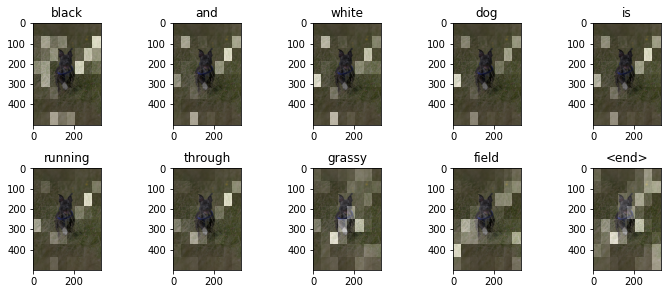

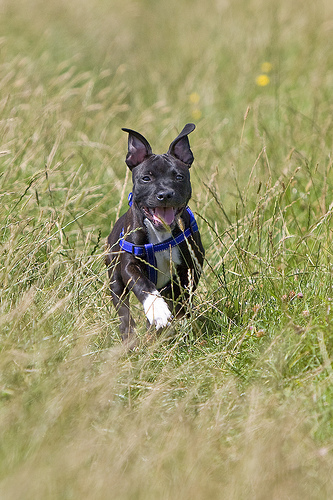

In [ ]:
#part2
#Checking other caption
#random = np.random.randint(0, len(image_name_validation))
random=25
image = image_name_validation[random]

real_cap = ' '.join([tokenizer.index_word[i] for i in cap_val[random] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_cap
first = real_cap.split(' ', 1)[1]
real_cap = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_cap:
   if i=="<unk>":
       real_cap.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
final_result = result_join.rsplit(' ', 1)[0]

rl_apn = []
rl_apn.append(real_cap.split())
reference = rl_apn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_cap)
print ('Prediction Caption:', final_result)

plot_attention(image, result, attention_plot)
Image.open(image_name_validation[random])

In [ ]:
#part2
#Checking other caption
random = np.random.randint(0, len(image_name_validation))
image = image_name_validation[random]

real_cap = ' '.join([tokenizer.index_word[i] for i in cap_val[random] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_cap
first = real_cap.split(' ', 1)[1]
real_cap = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_cap:
   if i=="<unk>":
       real_cap.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
final_result = result_join.rsplit(' ', 1)[0]

rl_apn = []
rl_apn.append(real_cap.split())
reference = rl_apn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_cap)
print ('Prediction Caption:', final_result)

plot_attention(image, result, attention_plot)
Image.open(image_name_validation[random])

In [ ]:
#part2
#Checking other caption
random = np.random.randint(0, len(image_name_validation))
image = image_name_validation[random]

real_cap = ' '.join([tokenizer.index_word[i] for i in cap_val[random] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_cap
first = real_cap.split(' ', 1)[1]
real_cap = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_cap:
   if i=="<unk>":
       real_cap.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
final_result = result_join.rsplit(' ', 1)[0]

rl_apn = []
rl_apn.append(real_cap.split())
reference = rl_apn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_cap)
print ('Prediction Caption:', final_result)

plot_attention(image, result, attention_plot)
Image.open(image_name_validation[random])

Transformer Model

In [ ]:
##part3 Continuation
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE

def map_func(img_name, cap):
   img_tensor = np.load(img_name.decode('utf-8')+'.npy')
   return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
#positional Encoding
def get_angles(pos, i, d_model):
   angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
   return pos * angle_rates

def positional_encoding_1d(position, d_model):
   angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis, :],
                           d_model)

   angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
   angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
   pos_encoding = angle_rads[np.newaxis, ...]
   return tf.cast(pos_encoding, dtype=tf.float32)

def positional_encoding_2d(row,col,d_model):
   assert d_model % 2 == 0
   row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
   col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)

   angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
   angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)

   angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
   angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
   angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
   angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
   pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]
   return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
#multi-head attention
def create_padding_mask(seq):
   seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
   return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
   mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
   return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(q, k, v, mask):
   matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
   dk = tf.cast(tf.shape(k)[-1], tf.float32)
   scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

   if mask is not None:
      scaled_attention_logits += (mask * -1e9) 

   attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
   output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

   return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads):
      super(MultiHeadAttention, self).__init__()
      self.num_heads = num_heads
      self.d_model = d_model
      assert d_model % self.num_heads == 0
      self.depth = d_model // self.num_heads
      self.wq = tf.keras.layers.Dense(d_model)
      self.wk = tf.keras.layers.Dense(d_model)
      self.wv = tf.keras.layers.Dense(d_model)
      self.dense = tf.keras.layers.Dense(d_model)

   def split_heads(self, x, batch_size):
      x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
      return tf.transpose(x, perm=[0, 2, 1, 3])

   def call(self, v, k, q, mask=None):
      batch_size = tf.shape(q)[0]
      q = self.wq(q)  # (batch_size, seq_len, d_model)
      k = self.wk(k)  # (batch_size, seq_len, d_model)
      v = self.wv(v)  # (batch_size, seq_len, d_model)

      q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
      k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
      v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

      scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
      scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q,      num_heads, depth)

      concat_attention = tf.reshape(scaled_attention,
                                 (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

      output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
      return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
   return tf.keras.Sequential([tf.keras.layers.Dense(dff, activation='relu'),
                               tf.keras.layers.Dense(d_model)])  # (batch_size, seq_len, d_model)])

In [ ]:
#encoder-decoder layer
class EncoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(EncoderLayer, self).__init__()
      self.mha = MultiHeadAttention(d_model, num_heads)
      self.ffn = point_wise_feed_forward_network(d_model, dff)

      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)


   def call(self, x, training, mask=None):
      attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
      attn_output = self.dropout1(attn_output, training=training)
      out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

      ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
      ffn_output = self.dropout2(ffn_output, training=training)
      out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
      return out2

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(DecoderLayer, self).__init__()
      self.mha1 = MultiHeadAttention(d_model, num_heads)
      self.mha2 = MultiHeadAttention(d_model, num_heads)

      self.ffn = point_wise_feed_forward_network(d_model, dff)

      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)
      self.dropout3 = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
      attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
      attn1 = self.dropout1(attn1, training=training)
      out1 = self.layernorm1(attn1 + x)

      attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) 
      attn2 = self.dropout2(attn2, training=training)
      out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

      ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
      ffn_output = self.dropout3(ffn_output, training=training)
      out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

      return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(tf.keras.layers.Layer):
   def __init__(self, num_layers, d_model, num_heads, dff, row_size,col_size,rate=0.1):
      super(Encoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
      self.pos_encoding = positional_encoding_2d(row_size,col_size,self.d_model)

      self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, training, mask=None):
      seq_len = tf.shape(x)[1]
      x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x = self.enc_layers[i](x, training, mask)

      return x  # (batch_size, input_seq_len, d_model)

In [ ]:
class Decoder(tf.keras.layers.Layer):
   def __init__(self, num_layers,d_model,num_heads,dff, target_vocab_size, maximum_position_encoding,   rate=0.1):
      super(Decoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
      self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

      self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                         for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
      seq_len = tf.shape(x)[1]
      attention_weights = {}

      x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
      x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                            look_ahead_mask, padding_mask)
         
         attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
         attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

      return x, attention_weights


In [ ]:
##Transformers
class Transformer(tf.keras.Model):
   def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size,
              target_vocab_size,max_pos_encoding, rate=0.1):
      super(Transformer, self).__init__()
      self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)
      self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                          target_vocab_size,max_pos_encoding, rate)
      self.final_layer = tf.keras.layers.Dense(target_vocab_size)

   def call(self, inp, tar, training,look_ahead_mask=None,dec_padding_mask=None,enc_padding_mask=None   ):
      enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model      )
      dec_output, attention_weights = self.decoder(
      tar, enc_output, training, look_ahead_mask, dec_padding_mask)
      final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
      return final_output, attention_weights

In [ ]:
##Hyperparameters
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1 

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
   def __init__(self, d_model, warmup_steps=4000):
      super(CustomSchedule, self).__init__()
      self.d_model = d_model
      self.d_model = tf.cast(self.d_model, tf.float32)
      self.warmup_steps = warmup_steps

   def __call__(self, step):
      arg1 = tf.math.rsqrt(step)
      arg2 = step * (self.warmup_steps ** -1.5)
      return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                    epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
   mask = tf.math.logical_not(tf.math.equal(real, 0))
   loss_ = loss_object(real, pred)
   mask = tf.cast(mask, dtype=loss_.dtype)
   loss_ *= mask
   return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,
                          max_pos_encoding=target_vocab_size,rate=dropout_rate)

Transformer Model Training

In [ ]:
def create_masks_decoder(tar):
   look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
   dec_target_padding_mask = create_padding_mask(tar)
   combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
   return combined_mask

In [ ]:
@tf.function
def train_step(img_tensor, tar):
   tar_inp = tar[:, :-1]
   tar_real = tar[:, 1:]
   dec_mask = create_masks_decoder(tar_inp)
   with tf.GradientTape() as tape:
      predictions, _ = transformer(img_tensor, tar_inp,True, dec_mask)
      loss = loss_function(tar_real, predictions)

   gradients = tape.gradient(loss, transformer.trainable_variables)   
   optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
   train_loss(loss)
   train_accuracy(tar_real, predictions)

In [ ]:
for epoch in range(30):
   start = time.time()
   train_loss.reset_states()
   train_accuracy.reset_states()
   for (batch, (img_tensor, tar)) in enumerate(dataset):
      train_step(img_tensor, tar)
      if batch % 50 == 0:
         print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
         epoch + 1, batch, train_loss.result(), train_accuracy.result()))

   print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                               train_loss.result(),
                                               train_accuracy.result()))
   print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.5868 Accuracy 0.0010
Epoch 1 Batch 50 Loss 8.1592 Accuracy 0.0199
Epoch 1 Batch 100 Loss 7.7533 Accuracy 0.0255
Epoch 1 Batch 150 Loss 7.4512 Accuracy 0.0278
Epoch 1 Batch 200 Loss 7.1544 Accuracy 0.0308
Epoch 1 Batch 250 Loss 6.8730 Accuracy 0.0344
Epoch 1 Batch 300 Loss 6.6194 Accuracy 0.0384
Epoch 1 Batch 350 Loss 6.4014 Accuracy 0.0419
Epoch 1 Batch 400 Loss 6.2082 Accuracy 0.0454
Epoch 1 Batch 450 Loss 6.0372 Accuracy 0.0486
Epoch 1 Loss 5.8914 Accuracy 0.0513
Time taken for 1 epoch: 72.71446514129639 secs

Epoch 2 Batch 0 Loss 4.3073 Accuracy 0.0791
Epoch 2 Batch 50 Loss 4.4168 Accuracy 0.0800
Epoch 2 Batch 100 Loss 4.3683 Accuracy 0.0816
Epoch 2 Batch 150 Loss 4.3156 Accuracy 0.0823
Epoch 2 Batch 200 Loss 4.2638 Accuracy 0.0833
Epoch 2 Batch 250 Loss 4.2199 Accuracy 0.0841
Epoch 2 Batch 300 Loss 4.1819 Accuracy 0.0852
Epoch 2 Batch 350 Loss 4.1441 Accuracy 0.0859
Epoch 2 Batch 400 Loss 4.1075 Accuracy 0.0865
Epoch 2 Batch 450 Loss 4.0730 Accuracy 0.0872
Ep

In [ ]:
#part 3 BLEU score
def evaluate(image):
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   start_token = tokenizer.word_index['<start>']
   end_token = tokenizer.word_index['<end>']
   decoder_input = [start_token]
   output = tf.expand_dims(decoder_input, 0) #tokens
   result = [] #word list

   for i in range(100):
      dec_mask = create_masks_decoder(output)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      if predicted_id == end_token:
         return result,tf.squeeze(output, axis=0), attention_weights
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

   return result,tf.squeeze(output, axis=0), attention_weights

In [ ]:
##Transformers BLEU score mean
score_tranf=[]
for random in range(len(image_name_validation)):
  image = image_name_validation[random]
  real_cap = ' '.join([tokenizer.index_word[i] for i in cap_val[random] if i not in [0]])
  caption,result,attention_weights = evaluate(image)

  first = real_cap.split(' ', 1)[1]
  real_cap = first.rsplit(' ', 1)[0]

  for i in caption:
    if i=="<unk>":
        caption.remove(i)

  for i in real_cap:
    if i=="<unk>":
        real_cap.remove(i)

  result_join = ' '.join(caption)
  final_result = result_join.rsplit(' ', 1)[0]
  rl_apn = []
  rl_apn.append(real_cap.split())
  reference = rl_apn
  candidate = caption

  
  score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
  
  score_tranf.append(score)
  
  print(f"BLEU1 score: {np.mean(score_tranf)}")


  ##print ('Real Caption:', real_cap)
  ##print ('Prediction Caption:', final_result)
  

Streaming output truncated to the last 5000 lines.
BLEU1 score: 0.2317159809278306
BLEU1 score: 0.23163879372565613
BLEU1 score: 0.23163315569844864
BLEU1 score: 0.23158234126071656
BLEU1 score: 0.23150527558974793
BLEU1 score: 0.2314947947928119
BLEU1 score: 0.2315452959716067
BLEU1 score: 0.231551431179063
BLEU1 score: 0.23157417912483264
BLEU1 score: 0.2316060456105823
BLEU1 score: 0.2316084493716519
BLEU1 score: 0.23157735585939015
BLEU1 score: 0.23158347024509895
BLEU1 score: 0.2315729913233189
BLEU1 score: 0.2315146107476082
BLEU1 score: 0.23151152971693
BLEU1 score: 0.23150108506007988
BLEU1 score: 0.23150644566805487
BLEU1 score: 0.2314897053692603
BLEU1 score: 0.23146994795678624
BLEU1 score: 0.2314746315972916
BLEU1 score: 0.23143696529260138
BLEU1 score: 0.2314781317910773
BLEU1 score: 0.23148425674749556
BLEU1 score: 0.23140773302625672
BLEU1 score: 0.23145518585737823
BLEU1 score: 0.2313787223007686
BLEU1 score: 0.2314438453873838
BLEU1 score: 0.23145747477904435
BLEU1 sco

In [ ]:
##BLEU 2 mean score
score_tranf=[]
for random in range(1000):
  image = image_name_validation[random]
  real_cap = ' '.join([tokenizer.index_word[i] for i in cap_val[random] if i not in [0]])
  caption,result,attention_weights = evaluate(image)

  first = real_cap.split(' ', 1)[1]
  real_cap = first.rsplit(' ', 1)[0]

  for i in caption:
    if i=="<unk>":
        caption.remove(i)

  for i in real_cap:
    if i=="<unk>":
        real_cap.remove(i)

  result_join = ' '.join(caption)
  final_result = result_join.rsplit(' ', 1)[0]
  rl_apn = []
  rl_apn.append(real_cap.split())
  reference = rl_apn
  candidate = caption

  
  score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
  
  score_tranf.append(score)
  
  print(f"BLEU2 score: {np.mean(score_tranf)}")


  ##print ('Real Caption:', real_cap)
  ##print ('Prediction Caption:', final_result)
  

BLEU2 score: 0.29642151188002913
BLEU2 score: 0.28184137689622674
BLEU2 score: 0.18789425126415116
BLEU2 score: 0.19295650456962143
BLEU2 score: 0.2121002305746597
BLEU2 score: 0.2788122647615155
BLEU2 score: 0.29808044765880937
BLEU2 score: 0.2692788469037465
BLEU2 score: 0.2568655343128135
BLEU2 score: 0.24853392864613816
BLEU2 score: 0.242326967375719
BLEU2 score: 0.24697825317774005
BLEU2 score: 0.2436817833357548
BLEU2 score: 0.23795093009217447
BLEU2 score: 0.24345288437892512
BLEU2 score: 0.24983549892371074
BLEU2 score: 0.2462712632756506
BLEU2 score: 0.23258952642700337
BLEU2 score: 0.24026042149670768
BLEU2 score: 0.25497352461311473
BLEU2 score: 0.27457795994899814
BLEU2 score: 0.27075586838497073
BLEU2 score: 0.28279789834671837
BLEU2 score: 0.2950709137985062
BLEU2 score: 0.3011566210665643
BLEU2 score: 0.3152146997434913
BLEU2 score: 0.3249234245377926
BLEU2 score: 0.3228516046485477
BLEU2 score: 0.31171879069514946
BLEU2 score: 0.3123414946660451
BLEU2 score: 0.305653736

In [ ]:
##BLEU 3 mean score
score_tranf=[]
for random in range(1000):
  image = image_name_validation[random]
  real_cap = ' '.join([tokenizer.index_word[i] for i in cap_val[random] if i not in [0]])
  caption,result,attention_weights = evaluate(image)

  first = real_cap.split(' ', 1)[1]
  real_cap = first.rsplit(' ', 1)[0]

  for i in caption:
    if i=="<unk>":
        caption.remove(i)

  for i in real_cap:
    if i=="<unk>":
        real_cap.remove(i)

  result_join = ' '.join(caption)
  final_result = result_join.rsplit(' ', 1)[0]
  rl_apn = []
  rl_apn.append(real_cap.split())
  reference = rl_apn
  candidate = caption

  
  score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
  
  score_tranf.append(score)
  
  print(f"BLEU3 score: {np.mean(score_tranf)}")


  ##print ('Real Caption:', real_cap)
  ##print ('Prediction Caption:', final_result)
  

BLEU3 score: 0.3692614485165609
BLEU3 score: 0.41116378539112425
BLEU3 score: 0.2741091902607495
BLEU3 score: 0.2937939553964727
BLEU3 score: 0.32993722044244916
BLEU3 score: 0.3991295349805781
BLEU3 score: 0.4157318679340669
BLEU3 score: 0.3749263829946461
BLEU3 score: 0.34836087721931336
BLEU3 score: 0.3410305280650242
BLEU3 score: 0.33945256247838057
BLEU3 score: 0.3327694375553868
BLEU3 score: 0.3206042271250818
BLEU3 score: 0.3197483467173993
BLEU3 score: 0.32374256048790284
BLEU3 score: 0.33441532141836827
BLEU3 score: 0.3316167435292266
BLEU3 score: 0.31319359111093625
BLEU3 score: 0.3138282112216901
BLEU3 score: 0.332472792022742
BLEU3 score: 0.3539765962922836
BLEU3 score: 0.3482869569274175
BLEU3 score: 0.35493479504480246
BLEU3 score: 0.37011347413980494
BLEU3 score: 0.3799902896830132
BLEU3 score: 0.38986945814007584
BLEU3 score: 0.4020677409246976
BLEU3 score: 0.4025012834462552
BLEU3 score: 0.3886219288446602
BLEU3 score: 0.39214686699085133
BLEU3 score: 0.387841539000964

In [ ]:
##BLEU 4 mean score
score_tranf=[]
for random in range(1000):
  image = image_name_validation[random]
  real_cap = ' '.join([tokenizer.index_word[i] for i in cap_val[random] if i not in [0]])
  caption,result,attention_weights = evaluate(image)

  first = real_cap.split(' ', 1)[1]
  real_cap = first.rsplit(' ', 1)[0]

  for i in caption:
    if i=="<unk>":
        caption.remove(i)

  for i in real_cap:
    if i=="<unk>":
        real_cap.remove(i)

  result_join = ' '.join(caption)
  final_result = result_join.rsplit(' ', 1)[0]
  rl_apn = []
  rl_apn.append(real_cap.split())
  reference = rl_apn
  candidate = caption

  
  score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
  
  score_tranf.append(score)
  
  print(f"BLEU4 score: {np.mean(score_tranf)}")


  ##print ('Real Caption:', real_cap)
  ##print ('Prediction Caption:', final_result)
  

BLEU4 score: 0.39011264866539486
BLEU4 score: 0.4535429013112827
BLEU4 score: 0.30236193420752183
BLEU4 score: 0.32742622493782597
BLEU4 score: 0.36939797313261497
BLEU4 score: 0.43825535928328635
BLEU4 score: 0.45342545933719824
BLEU4 score: 0.40870933898384987
BLEU4 score: 0.3814915800671661
BLEU4 score: 0.3742043683325494
BLEU4 score: 0.37424754286189077
BLEU4 score: 0.37011590724632476
BLEU4 score: 0.3596122981399998
BLEU4 score: 0.35976670261717736
BLEU4 score: 0.36218835193208254
BLEU4 score: 0.37335493374816153
BLEU4 score: 0.37011454644477865
BLEU4 score: 0.34955262719784647
BLEU4 score: 0.35131193983871667
BLEU4 score: 0.37030186513223207
BLEU4 score: 0.3915492325510651
BLEU4 score: 0.38463931018091824
BLEU4 score: 0.3923654847465457
BLEU4 score: 0.40767674311758934
BLEU4 score: 0.41811928559194267
BLEU4 score: 0.4234040748692663
BLEU4 score: 0.43586450489824136
BLEU4 score: 0.436808842406312
BLEU4 score: 0.4217464685302323
BLEU4 score: 0.42591394300230234
BLEU4 score: 0.42262

In [ ]:
score_tranf

In [ ]:
# creating a list of column names
column_values = ['transf_bleus']
  
# creating the dataframe for tranformer_bleu score
df_tranf = pd.DataFrame(data = score_tranf,columns = column_values)
##importing the dataframe to excel
df_tranf.to_excel("/content/drive/MyDrive/Disseration_SharedDrive/tranf_bleu.xlsx")



In [ ]:
##importing the dataframe to excel
df_tranf.to_excel("/content/drive/MyDrive/Disseration_SharedDrive/tranf_bleu.xlsx")

BLEU-1 score: 80.0
BLEU-2 score: 66.66666666666667
BLEU-3 score: 63.684866956664344
BLEU-4 score: 55.55238068023583
Real Caption: black dog with blue collar runs through the green grass
Predicted Caption: black and white dog with blue collar runs through grass


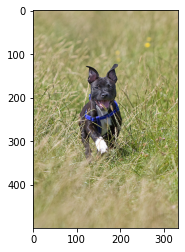

In [ ]:
#random = np.random.randint(0, len(image_name_validation))
random=25
image = image_name_validation[random]
real_cap = ' '.join([tokenizer.index_word[i] for i in cap_val[random] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_cap.split(' ', 1)[1]
real_cap = first.rsplit(' ', 1)[0]

for i in caption:
   if i=="<unk>":
      caption.remove(i)

for i in real_cap:
   if i=="<unk>":
      real_cap.remove(i)

result_join = ' '.join(caption)
final_result = result_join.rsplit(' ', 1)[0]
rl_apn = []
rl_apn.append(real_cap.split())
reference = rl_apn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")
print ('Real Caption:', real_cap)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

In [ ]:
##checking other image using part 3
random = np.random.randint(0, len(image_name_validation))
image = image_name_validation[random]
real_cap = ' '.join([tokenizer.index_word[i] for i in cap_val[random] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_cap.split(' ', 1)[1]
real_cap = first.rsplit(' ', 1)[0]

for i in caption:
   if i=="<unk>":
      caption.remove(i)

for i in real_cap:
   if i=="<unk>":
      real_cap.remove(i)

result_join = ' '.join(caption)
final_result = result_join.rsplit(' ', 1)[0]
rl_apn = []
rl_apn.append(real_cap.split())
reference = rl_apn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")
print ('Real Caption:', real_cap)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

In [ ]:
#Checking image captioning with the part 3-3 image
random = np.random.randint(0, len(image_name_validation))
image = image_name_validation[random]
real_cap = ' '.join([tokenizer.index_word[i] for i in cap_val[random] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_cap.split(' ', 1)[1]
real_cap = first.rsplit(' ', 1)[0]

for i in caption:
   if i=="<unk>":
      caption.remove(i)

for i in real_cap:
   if i=="<unk>":
      real_cap.remove(i)

result_join = ' '.join(caption)
final_result = result_join.rsplit(' ', 1)[0]
rl_apn = []
rl_apn.append(real_cap.split())
reference = rl_apn
candidate = caption


score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_cap)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

In [ ]:
##Transformers BLEU score in dataframe
score_tranf=[]
for random in range(len(image_name_validation)):
  image = image_name_validation[random]
  real_cap = ' '.join([tokenizer.index_word[i] for i in cap_val[random] if i not in [0]])
  caption,result,attention_weights = evaluate(image)

  first = real_cap.split(' ', 1)[1]
  real_cap = first.rsplit(' ', 1)[0]

  for i in caption:
    if i=="<unk>":
        caption.remove(i)

  for i in real_cap:
    if i=="<unk>":
        real_cap.remove(i)

  result_join = ' '.join(caption)
  final_result = result_join.rsplit(' ', 1)[0]
  rl_apn = []
  rl_apn.append(real_cap.split())
  reference = rl_apn
  candidate = caption

  
  score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
  print(f"BLEU score: {score*100}")
  score_tranf.append(score)

  print ('Real Caption:', real_cap)
  print ('Prediction Caption:', final_result)




In [ ]:
# creating a list of column names
column_values = ['transf1_bleus']
  
# creating the dataframe for tranformer_bleu score
df_tranf1 = pd.DataFrame(data = score_tranf,columns = column_values)
##importing the dataframe to excel
df_tranf1.to_excel("/content/drive/MyDrive/Disseration_SharedDrive/tranf1_bleu.xlsx")